In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Auxiliary Functions

In [2]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [3]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [4]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [5]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

In [6]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [7]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [8]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [9]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [10]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [11]:
def get_corresponding_df(df, group_name):
    if group_name == "Female_ADHD":
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif group_name == "Female_noADHD":
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif group_name == "ADHD":
        topic_df = df[df["group"].isin(["Male_ADHD", "Female_ADHD"])]
        print("ADHD")
    elif group_name == "noADHD":
        topic_df = df[df["group"].isin(["Male_noADHD", "Female_noADHD"])]
        print("noADHD")
    return topic_df

# Preload

In [12]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,need_fast_talk_interest,need_fast_talk_information,speaking_before_thinking,something_to_add,something_to_add_timid,something_to_add_impulsive,question,response,response_embedding,group
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,1,1,3,4,4,2,special_interest,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....",Female_noADHD
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,1,1,4,4,4,2,special_interest,Gosto de ver séries porque relatam relações sa...,"[0.011201557, -0.016555935, 0.05544479, 0.0285...",Female_noADHD
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,4,4,2,4,3,3,special_interest,Campos de ferias. Temos que criar o campo todo...,"[-0.010825635, -0.023888972, -0.013832389, -0....",Female_noADHD
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,2,3,3,5,4,4,special_interest,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...",Female_noADHD
15,2025-03-31T13:58:15+02:00,Feminino,Suspeito que tenho,25,Licenciatura,Trabalhador,Português de Portugal,4,2,5,...,2,2,3,5,5,3,special_interest,Historia da arte \nÉ só tão interessante. Para...,"[-0.026616443, -0.021927392, 0.014119624, 0.01...",Female_noADHD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2025-06-07T16:05:17+02:00,Feminino,"Sim, diagnosticado",51,Mestrado,Trabalhador-estudante,Português de Portugal,4,2,5,...,3,2,4,4,5,5,empty_sheet,"O ponto em que sociedade se está a tornar,: eg...","[-0.019272415, -0.014781286, 0.036758002, 0.00...",Female_ADHD
296,2025-06-07T17:23:10+02:00,Feminino,"Sim, diagnosticado",36,Pós-Graduação,Estudante,Português de Portugal,5,3,3,...,2,3,3,4,3,3,empty_sheet,Gostava que não dissessem : toda a gente tem p...,"[-0.05752369, 0.0008796515, -0.011525935, -0.0...",Female_ADHD
307,2025-06-10T16:58:08+02:00,Feminino,"Sim, diagnosticado",19,Ensino secundário,Trabalhador-estudante,Português de Portugal,4,2,4,...,4,4,4,5,4,4,empty_sheet,Não sei explicar o que se anda a passar comigo...,"[-0.026584908, -0.011627352, 0.029701553, -0.0...",Female_ADHD
308,2025-06-10T17:45:28+02:00,Masculino,"Sim, diagnosticado",19,Ensino secundário,Estudante,Português de Portugal,2,3,4,...,1,1,3,4,2,2,empty_sheet,"De momento, na minha cabeça, só rumino sobre o...","[-0.015350613, -0.020685123, 0.0079341745, -0....",Male_ADHD


In [13]:
def preliminary_steps(group_name, folder):
    print(f"Running preliminary steps for group: {group_name}, folder: {folder}")
    df_group = get_corresponding_df(topic_df, group_name)
    path = f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/{folder}/"
    output_folder = f"../../outputs/bertopic_tuning/{group_name}/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [14]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    
    # Generate and save hierarchical topics (this usually works fine)
    try:
        print("🔄 Generating hierarchical topics...")
        hierarchical_topics = topic_model.hierarchical_topics(texts)
        print("✅ Hierarchical topics generated successfully")
        
        # Visualize hierarchy (this also usually works)
        try:
            print("🔄 Creating hierarchy visualization...")
            fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
            save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Hierarchy visualization saved")
        except Exception as e:
            print(f"⚠️  Warning: Could not create hierarchy visualization: {e}")
            
    except Exception as e:
        print(f"⚠️  Warning: Could not generate hierarchical topics: {e}")
    
    # Get and save topic info (this always works)
    try:
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)
        
        num_unique_topics = topic_info['Topic'].nunique()
        num_real_topics = len(topic_info[topic_info['Topic'] != -1])  # Exclude outlier topic
        
        print(f"📊 Number of unique topics: {num_unique_topics}")
        print(f"📊 Number of real topics (excluding outliers): {num_real_topics}")
        
        # Save topic summary
        with open(f"{output_folder}/topic_summary.txt", "w") as f:
            f.write(f"Total unique topics: {num_unique_topics}\n")
            f.write(f"Real topics (excluding outliers): {num_real_topics}\n")
            f.write(f"Total documents: {len(texts)}\n")
            f.write(f"Documents per topic (avg): {len(texts) / max(num_real_topics, 1):.2f}\n")
            
    except Exception as e:
        print(f"❌ Error getting topic info: {e}")
        return topic_model
    
    # Try to create topic visualization with enhanced error handling
    if num_real_topics <= 3:
        print("⚠️  Cannot create topic visualization: Need at least 3 real topics")
        print("💡 This model has too few distinct topics for meaningful visualization")
        
        # Save a note about why visualization was skipped
        with open(f"{output_folder}/visualization_notes.txt", "w") as f:
            f.write(f"Topic visualization skipped: Only {num_real_topics} real topics found\n")
            f.write("Minimum 2 topics required for UMAP dimensionality reduction\n")
            
    elif num_real_topics <= 4:
        print("⚠️  Very few topics detected. Attempting visualization with fallback options...")
        
        # Try with different UMAP parameters for small datasets
        try:
            print("🔄 Attempting topic visualization with adjusted parameters...")
            
            # Create a custom UMAP with parameters suitable for small datasets
            from umap import UMAP
            
            # Override the model's UMAP temporarily with safer parameters
            original_umap = topic_model.umap_model
            
            # Use parameters that work better with few topics
            safe_umap = UMAP(
                n_neighbors=min(2, num_real_topics),  # Very small n_neighbors
                n_components=2,
                metric="cosine",
                random_state=42,
                min_dist=0.1,
                spread=1.0
            )
            
            topic_model.umap_model = safe_umap
            
            # Try the visualization
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created with adjusted parameters")
            
            # Restore original UMAP
            topic_model.umap_model = original_umap
            
        except (TypeError, ValueError) as e:
            if "k >= N" in str(e) or "zero-size array" in str(e):
                print("⚠️  UMAP spectral initialization failed due to insufficient data")
                print("💡 This is expected with very few topics - the model is still valid")
                
                # Save detailed error info
                with open(f"{output_folder}/visualization_error.txt", "w") as f:
                    f.write(f"Visualization failed due to insufficient topic diversity\n")
                    f.write(f"Error: {str(e)}\n")
                    f.write(f"Real topics: {num_real_topics}\n")
                    f.write(f"This is a known limitation when fewer than 5-6 topics exist\n")
                    
            else:
                print(f"❌ Unexpected error in topic visualization: {e}")
                
        except Exception as e:
            print(f"❌ Other error in topic visualization: {e}")
            
    else:
        # Normal case: enough topics for standard visualization
        try:
            print("🔄 Creating standard topic visualization...")
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created successfully")
        except Exception as e:
            print(f"❌ Error in standard topic visualization: {e}")
    
    return topic_model

In [15]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [16]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    
    # Check topic distribution before attempting datamap
    topic_info = topic_model.get_topic_info()
    real_topics = topic_info[topic_info['Topic'] != -1]
    print(f"Number of real topics (excluding outliers): {len(real_topics)}")
    
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)

    # Check if we have enough valid topics for datamap visualization
    if len(real_topics) < 2:
        print(f"⚠️  Skipping document datamap: Only {len(real_topics)} real topics found (minimum 2 required)")
        with open(f"{output_folder}/datamap_skipped.txt", "w") as f:
            f.write(f"Document datamap skipped: Only {len(real_topics)} real topics found\n")
            f.write("Minimum 2 real topics required for meaningful datamap visualization\n")
    else:
        try:
            print("🔄 Creating document datamap...")
            embeddings = np.vstack(df_group["response_embedding"])
            fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
            save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Document datamap created successfully")
        except ValueError as e:
            if "array of sample points is empty" in str(e):
                print("⚠️  Skipping document datamap: Insufficient valid data points for visualization")
                print("💡 This typically happens when most documents are classified as outliers")
                with open(f"{output_folder}/datamap_error.txt", "w") as f:
                    f.write(f"Document datamap failed: {str(e)}\n")
                    f.write("This typically indicates insufficient topic diversity or too many outliers\n")
            else:
                print(f"❌ Unexpected error in document datamap: {e}")
                raise e
        except Exception as e:
            print(f"❌ Error creating document datamap: {e}")

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Save translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    else:
        print("No valid topics to display")

# Female ADHD

In [38]:
group_name = "Female_ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['6_20250824_194550',
 '2_reduced_5_20250827_011928',
 '10_20250824_201400',
 '4_20250824_194550',
 '8_20250824_201243',
 '2_20250824_194550',
 '2_reduced_9_20250825_011741',
 '5_20250824_194550',
 '3_20250824_194550',
 '2_reduced_3_20250827_022655',
 '7_20250824_201138',
 '2_reduced_4_20250827_021816']

Found folder: 2_reduced_3_20250827_022655
Running preliminary steps for group: Female_ADHD, folder: 2_reduced_3_20250827_022655
Female_ADHD
🔄 Generating hierarchical topics...


100%|██████████| 1/1 [00:00<00:00, 364.25it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250827_023015_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250827_023015_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_3_20250827_022655
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 59 documents across 2 topics
Silhouette Score: 0.0737
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.4874
Individual Topic Coherences:
  Topic 0: -0.8670
  Topic 1: -0.1078
Coherence results saved to 

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Pedras, necrópoles, minerais, música, cinema, ...",0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
1,Um dos meus interesses especiais é skincare co...,-1,-1_comigo_amigos_falar_pessoas,Outlier Topic,"[comigo, amigos, falar, pessoas, sempre, vida,...","[tornei, comigo mesma, comigo própria, mim, co...",[Personal Identity and Social Belonging],"[amigos, sempre, vida, nunca, mim, ano, social...","[comigo, amigos, pessoas, vida, dia, tanto, an...",NaN,comigo - amigos - falar - pessoas - sempre - v...,False
2,Pergunta difícil porque tenho vários e eles vã...,0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
3,"Animais, sempre amei animais e é a minha maior...",1,1_serem_motivos_verdadeiramente_tendência,Animal Welfare and Human Responsibility,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[Animal Welfare and Human Responsibility],"[motivos, tendência, sociedade, problemas, ass...","[tendência, motivos, sociedade, comportamento,...",NaN,serem - motivos - verdadeiramente - tendência ...,False
4,"Adoro ler, embora agora esteja sem muita vonta...",0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,A PHDA influencia tudo na minha vida. Mas prin...,0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
61,"""O serial killer e o bode espiatorio"". O pânic...",0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
62,"O ponto em que sociedade se está a tornar,: eg...",0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False
63,Gostava que não dissessem : toda a gente tem p...,0,0_porque_ainda_dia_bem,Personal Reflections and Daily Life,"[porque, ainda, dia, bem, fazer, vida, pessoas...","[comecei, cansada, horas, tirar, memória, ansi...",[Personal Reflections and Daily Life],"[vida, anos, coisas, nunca, mim, memória, come...","[dia, vida, pessoas, anos, trabalho, casa, coi...",NaN,porque - ainda - dia - bem - fazer - vida - pe...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250827_023016_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250827_023016_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_3_20250827_022655
------------------------------------------------------------


4it [00:00, 190.45it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250827_023018_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250827_023018_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_3_20250827_022655
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250827_023021_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250827_023021_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_3_20250827_022655
------------------------------------

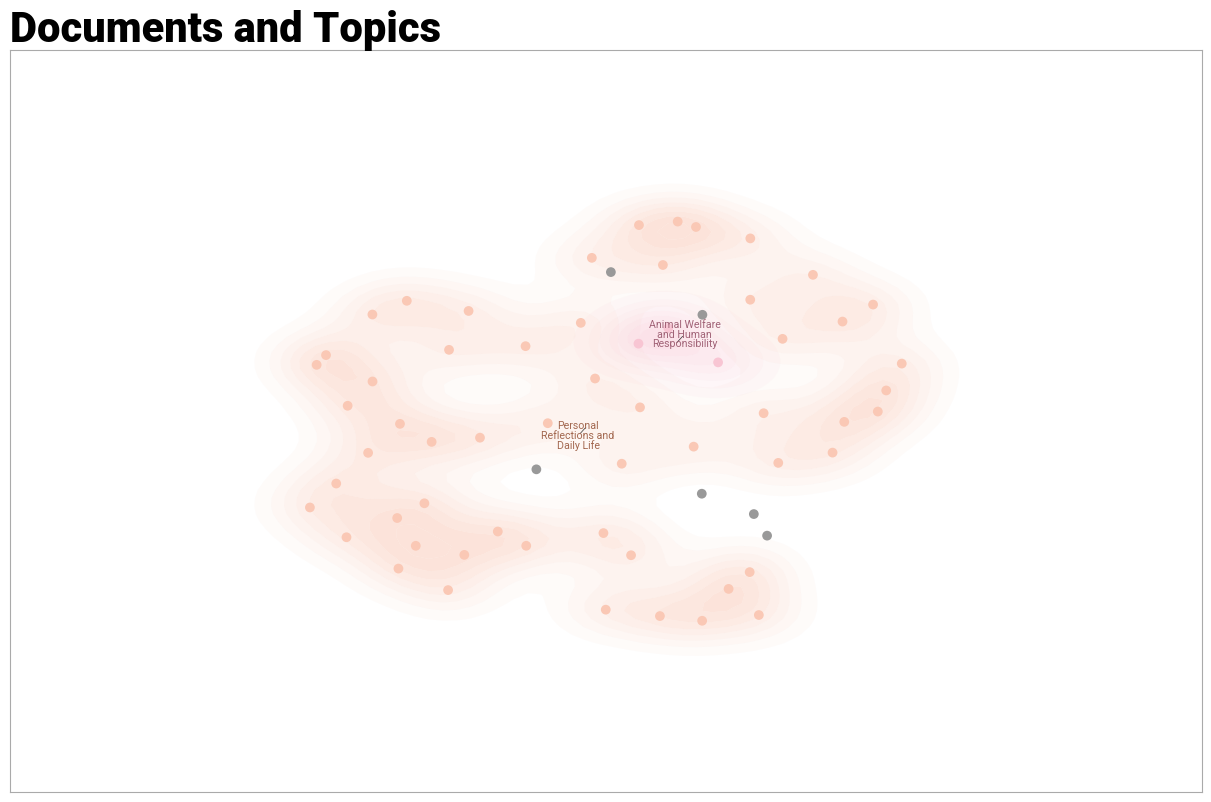

In [ ]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# Female no-ADHD

In [40]:
group_name = "Female_noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['6_20250824_205040',
 '3_reduced_16_20250825_012136',
 '12_20250824_210406',
 '3_20250824_203413',
 '4_20250824_204001',
 '2_20250824_202655',
 '5_20250824_204338',
 '7_20250824_205357',
 '15_20250824_214606',
 '8_20250824_205621',
 '2_reduced_30_20250827_024235',
 '10_20250824_210048']

Found folder: 2_reduced_30_20250827_024235
Running preliminary steps for group: Female_noADHD, folder: 2_reduced_30_20250827_024235
Female_noADHD
🔄 Generating hierarchical topics...


100%|██████████| 28/28 [00:00<00:00, 549.21it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250827_025509_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250827_025509_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_reduced_30_20250827_024235
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 30
📊 Number of real topics (excluding outliers): 29
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250827_025511_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250827_025511_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-w

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",23,23_cozinhar_adoro_desligar_outras pessoas,Feelings About Cooking,"[cozinhar, adoro, desligar, outras pessoas, po...","[cozinhar, fazer, porque gosto, comida, gosto ...",[Feelings About Cooking],"[cozinhar, desligar, lista, porque gosto, proj...","[ideal, lista, sorte, comida, cérebro, emoções...",NaN,cozinhar - adoro - desligar - outras pessoas -...,False
1,Gosto de ver séries porque relatam relações sa...,12,12_historia_forma_saudáveis_adoro,Comfort in Fictional Stories,"[historia, forma, saudáveis, adoro, devo visto...","[ver séries, séries, histórias, gosto ver, gos...",[Comfort in Fictional Stories],"[saudáveis, devo visto, empatia, harry potter,...","[historia, forma, saudáveis, vivo, vista, melh...",NaN,historia - forma - saudáveis - adoro - devo vi...,False
2,Campos de ferias. Temos que criar o campo todo...,-1,-1_pai_momento_passar_disse,Outlier Topic,"[pai, momento, passar, disse, ir, tempo, dia, ...","[ir, altura, hoje senti, tempo, fazer, sentia,...",[Personal Growth and Overcoming Challenges],"[momento, tempo, dias, apesar, finalmente, 100...","[pai, momento, tempo, dia, manhã, semana, dias...",NaN,pai - momento - passar - disse - ir - tempo - ...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",-1,-1_pai_momento_passar_disse,Outlier Topic,"[pai, momento, passar, disse, ir, tempo, dia, ...","[ir, altura, hoje senti, tempo, fazer, sentia,...",[Personal Growth and Overcoming Challenges],"[momento, tempo, dias, apesar, finalmente, 100...","[pai, momento, tempo, dia, manhã, semana, dias...",NaN,pai - momento - passar - disse - ir - tempo - ...,False
4,Historia da arte \nÉ só tão interessante. Para...,22,22_historia_arte_fácil_cultura,World History and Culture,"[historia, arte, fácil, cultura, interessante,...","[historia, história, cultura, geral, arte, mun...",[World History and Culture],"[historia, arte, fácil, cultura, interessante,...","[arte, fácil, cultura, interessante, história,...",NaN,historia - arte - fácil - cultura - interessan...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
215,A noção de que procuro ser sempre uma boa pess...,2,2_perceber_menos_sempre_algum,Self-Reflection and Digital Wellbeing,"[perceber, menos, sempre, algum, chatgpt, impa...","[dificuldades, concentrar, mim sinto, comigo m...",[Self-Reflection and Digital Wellbeing],"[chatgpt, muitas vezes, atividades, cérebro, d...","[algum, impacto, uso, tipo, atividades, cérebr...",NaN,perceber - menos - sempre - algum - chatgpt - ...,False
216,—,17,17_biblioteca_escrita_pessoas_,Communication Through Writing and Meaning,"[biblioteca, escrita, pessoas, , , , , , , ]","[escrita, , , , , , , , , ]",[Communication Through Writing and Meaning],"[biblioteca, escrita, pessoas, , , , , , , , ,...","[biblioteca, escrita, pessoas, , , , , , , ]",NaN,biblioteca - escrita - pessoas - - - - - ...,False
217,As vezes aborrece-me ter de escrever/responder...,-1,-1_pai_momento_passar_disse,Outlier Topic,"[pai, momento, passar, disse, ir, tempo, dia, ...","[ir, altura, hoje senti, tempo, fazer, sentia,...",[Personal Growth and Overcoming Challenges],"[momento, tempo, dias, apesar, finalmente, 100...","[pai, momento, tempo, dia, manhã, semana, dias...",NaN,pai - momento - passar - disse - ir - tempo - ...,False
218,Maiores dificuldades que sempre senti.. Concen...,2,2_perceber_menos_sempre_algum,Self-Reflection and Digital Wellbeing,"[perceber, menos, sempre, algum, chatgpt, impa...","[dificuldades, concentrar, mim sinto, comigo m...",[Self-Reflection and Digital Wellbeing],"[chatgpt, muitas vezes, atividades, cérebro, d...","[algum, impacto, uso, tipo, atividades, cérebr...",NaN,perceber - menos - sempre - algum - chatgpt - ...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250827_025513_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250827_025513_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_reduced_30_20250827_024235
------------------------------------------------------------


4it [00:00, 105.81it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250827_025515_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250827_025515_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_reduced_30_20250827_024235
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250827_025522_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250827_025522_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_reduced_30_20250827_024235
----------

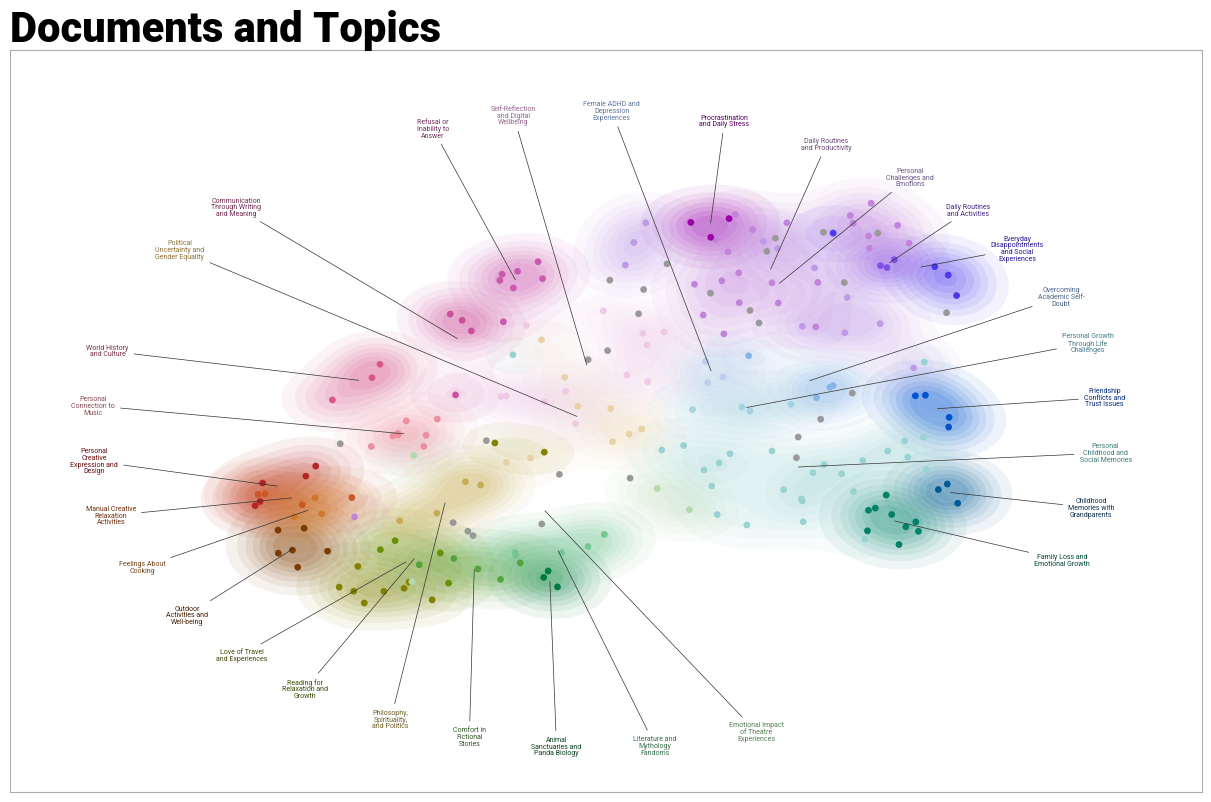

In [ ]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# ADHD

In [36]:
group_name = "ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['4_20250824_215317',
 '3_reduced_6_20250827_022134',
 '2_reduced_13_20250827_014303',
 '7_20250824_215640',
 '2_reduced_10_20250827_012252',
 '12_20250824_215938',
 '2_reduced_7_20250827_020707',
 '10_20250824_215848',
 '5_20250824_215438',
 '2_reduced_12_20250827_013654',
 '2_reduced_9_20250827_020215',
 '2_reduced_8_20250827_013137',
 '2_20250824_214730',
 '8_20250824_215742',
 '2_reduced_11_20250827_015300',
 '6_20250824_215554',
 '3_20250824_215043']

Found folder: 3_reduced_6_20250827_022134
Running preliminary steps for group: ADHD, folder: 3_reduced_6_20250827_022134
ADHD
🔄 Generating hierarchical topics...


100%|██████████| 4/4 [00:00<00:00, 378.89it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250827_022610_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250827_022610_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_reduced_6_20250827_022134
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 6
📊 Number of real topics (excluding outliers): 5
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_ADHD as PNG: 20250827_022611_bertopic_topics_adhd.png
📊 Saved bertopic_topics_ADHD as HTML: 20250827_022611_bertopic_topics_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_reduced_6_20250827_022134
----------------------------------------

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Não estudo no sentido literal, mas interesso-m...",1,1_saúde_etc_jogo_tudo,Human Curiosity and Well-being,"[saúde, etc, jogo, tudo, gosto, sempre, adoro,...","[altos baixos, mental, aborrecimento, saúde me...",[Human Curiosity and Well-being],"[jogo, gosto, tipo, comportamento, especiais, ...","[saúde, jogo, gosto, animal, mental, interesse...",NaN,saúde - etc - jogo - tudo - gosto - sempre - a...,False
1,Linux!,-1,-1_comigo_pessoas_falar_vida,Outlier Topic,"[comigo, pessoas, falar, vida, amigos, mim, ve...","[vezes sinto, comigo mesma, mim, sinto, depres...","[Identity, Belonging, Social Struggles]","[comigo, falar, amigos, vezes, nunca, nesse di...","[comigo, pessoas, vida, amigos, vezes, dia, an...",NaN,comigo - pessoas - falar - vida - amigos - mim...,False
2,Gosto muito de arrumação gosto de ter tudo arr...,0,0_dia_hoje_fazer_porque,Daily Life and Routines,"[dia, hoje, fazer, porque, semana, trabalho, a...","[acordei, tempo, horas, comecei, cansada, hoje...",[Daily Life and Routines],"[hoje, fazer, acordei, comecei, sinto, demasia...","[dia, semana, trabalho, casa, horas, tempo, al...",NaN,dia - hoje - fazer - porque - semana - trabalh...,False
3,"Gosto imenso de montanhas russas, às vezes gos...",1,1_saúde_etc_jogo_tudo,Human Curiosity and Well-being,"[saúde, etc, jogo, tudo, gosto, sempre, adoro,...","[altos baixos, mental, aborrecimento, saúde me...",[Human Curiosity and Well-being],"[jogo, gosto, tipo, comportamento, especiais, ...","[saúde, jogo, gosto, animal, mental, interesse...",NaN,saúde - etc - jogo - tudo - gosto - sempre - a...,False
4,"Pedras, necrópoles, minerais, música, cinema, ...",4,4_tão_áreas_mundo_apenas,Human Creativity and Complex Worlds,"[tão, áreas, mundo, apenas, interesse especial...","[fascinante, interesse especial, criar, compos...",[Human Creativity and Complex Worlds],"[interesse especial, composição, mente, mundo ...","[áreas, mundo, especial, interesse, mente, fas...",NaN,tão - áreas - mundo - apenas - interesse espec...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
89,"""O serial killer e o bode espiatorio"". O pânic...",2,2_phda_pessoas_lá_porque,Adult ADHD Diagnosis and Challenges,"[phda, pessoas, lá, porque, continua, vida, me...","[psiquiatra, diagnóstico, pânico, depressão, p...",[Adult ADHD Diagnosis and Challenges],"[phda, vida, medicação, diagnóstico, comer, co...","[phda, pessoas, vida, medicação, diagnóstico, ...",NaN,phda - pessoas - lá - porque - continua - vida...,False
90,"O ponto em que sociedade se está a tornar,: eg...",-1,-1_comigo_pessoas_falar_vida,Outlier Topic,"[comigo, pessoas, falar, vida, amigos, mim, ve...","[vezes sinto, comigo mesma, mim, sinto, depres...","[Identity, Belonging, Social Struggles]","[comigo, falar, amigos, vezes, nunca, nesse di...","[comigo, pessoas, vida, amigos, vezes, dia, an...",NaN,comigo - pessoas - falar - vida - amigos - mim...,False
91,Gostava que não dissessem : toda a gente tem p...,2,2_phda_pessoas_lá_porque,Adult ADHD Diagnosis and Challenges,"[phda, pessoas, lá, porque, continua, vida, me...","[psiquiatra, diagnóstico, pânico, depressão, p...",[Adult ADHD Diagnosis and Challenges],"[phda, vida, medicação, diagnóstico, comer, co...","[phda, pessoas, vida, medicação, diagnóstico, ...",NaN,phda - pessoas - lá - porque - continua - vida...,False
92,Não sei explicar o que se anda a passar comigo...,-1,-1_comigo_pessoas_falar_vida,Outlier Topic,"[comigo, pessoas, falar, vida, amigos, mim, ve...","[vezes sinto, comigo mesma, mim, sinto, depres...","[Identity, Belonging, Social Struggles]","[comigo, falar, amigos, vezes, nunca, nesse di...","[comigo, pessoas, vida, amigos, vezes, dia, an...",NaN,comigo - pessoas - falar - vida - amigos - mim...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250827_022613_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250827_022613_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_reduced_6_20250827_022134
------------------------------------------------------------


4it [00:00, 151.99it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250827_022614_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250827_022614_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_reduced_6_20250827_022134
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250827_022618_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250827_022618_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_reduced_6_20250827_022134
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic w

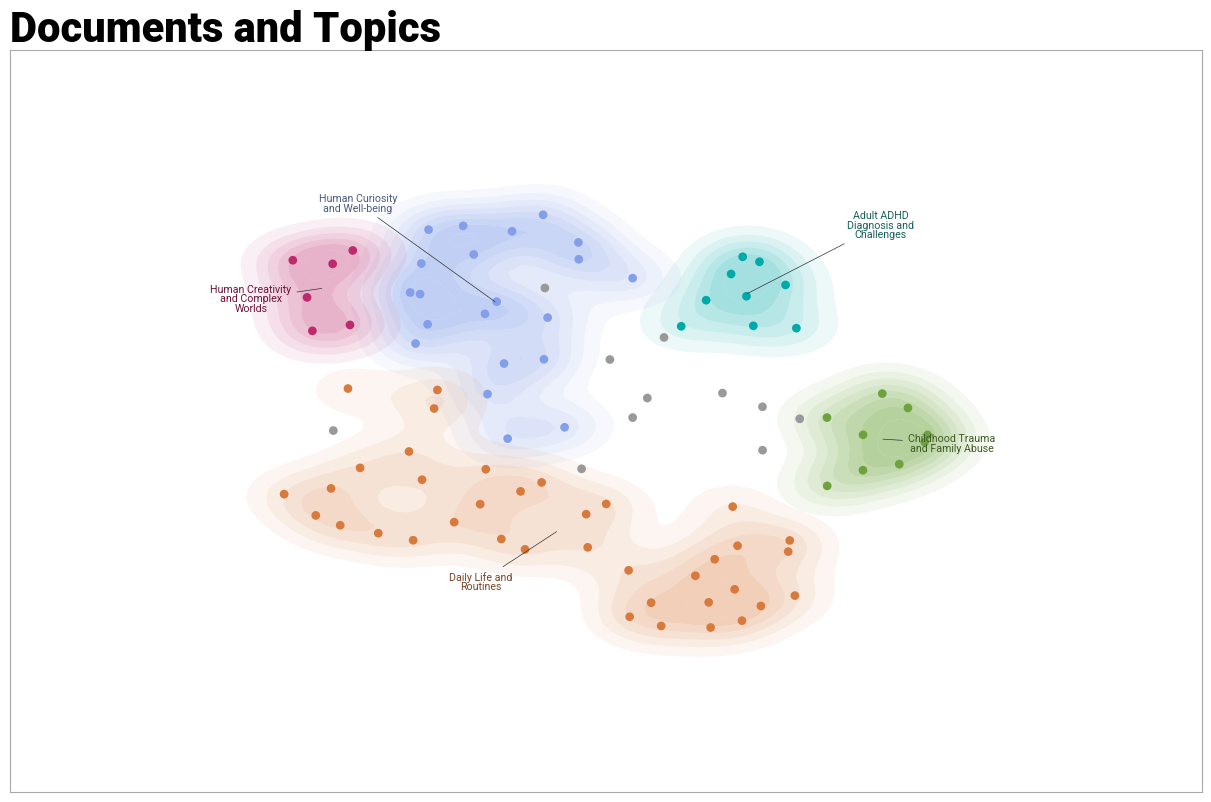

In [ ]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# no-ADHD

In [18]:
group_name = "noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['3_reduced_27_20250825_015611',
 '20_20250824_225247',
 '12_20250824_225018',
 '6_20250824_224207',
 '2_20250824_221352',
 '15_20250824_225147',
 '10_20250824_224844',
 '3_20250824_222353',
 '5_20250824_223659',
 '8_20250824_224646',
 '7_20250824_224526',
 '4_20250824_223137',
 '25_20250824_225346']

Found folder: 8_20250824_224646
Running preliminary steps for group: noADHD, folder: 8_20250824_224646
noADHD
🔄 Generating hierarchical topics...


100%|██████████| 3/3 [00:00<00:00, 322.15it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023622_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023622_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023631_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023631_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-port

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sentir, livros, espec...","[gosto, forma, interesse, desporto, mundo, dia...",NaN,gosto - porque - forma - adoro - ler - interes...,False
1,Gosto de ver séries porque relatam relações sa...,1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sentir, livros, espec...","[gosto, forma, interesse, desporto, mundo, dia...",NaN,gosto - porque - forma - adoro - ler - interes...,False
2,Campos de ferias. Temos que criar o campo todo...,0,0_dia_fazer_hoje_porque,Personal Challenges and Emotional Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, ia, senti, comecei, comigo, fiz, medo...",[Personal Challenges and Emotional Reflections],"[fazer, hoje, tempo, coisas, tarde, senti, ape...","[dia, tempo, trabalho, anos, coisas, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sentir, livros, espec...","[gosto, forma, interesse, desporto, mundo, dia...",NaN,gosto - porque - forma - adoro - ler - interes...,False
4,Historia da arte \nÉ só tão interessante. Para...,1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sentir, livros, espec...","[gosto, forma, interesse, desporto, mundo, dia...",NaN,gosto - porque - forma - adoro - ler - interes...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
348,A noção de que procuro ser sempre uma boa pess...,0,0_dia_fazer_hoje_porque,Personal Challenges and Emotional Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, ia, senti, comecei, comigo, fiz, medo...",[Personal Challenges and Emotional Reflections],"[fazer, hoje, tempo, coisas, tarde, senti, ape...","[dia, tempo, trabalho, anos, coisas, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
349,—,0,0_dia_fazer_hoje_porque,Personal Challenges and Emotional Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, ia, senti, comecei, comigo, fiz, medo...",[Personal Challenges and Emotional Reflections],"[fazer, hoje, tempo, coisas, tarde, senti, ape...","[dia, tempo, trabalho, anos, coisas, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
350,As vezes aborrece-me ter de escrever/responder...,0,0_dia_fazer_hoje_porque,Personal Challenges and Emotional Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, ia, senti, comecei, comigo, fiz, medo...",[Personal Challenges and Emotional Reflections],"[fazer, hoje, tempo, coisas, tarde, senti, ape...","[dia, tempo, trabalho, anos, coisas, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
351,Maiores dificuldades que sempre senti.. Concen...,0,0_dia_fazer_hoje_porque,Personal Challenges and Emotional Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, ia, senti, comecei, comigo, fiz, medo...",[Personal Challenges and Emotional Reflections],"[fazer, hoje, tempo, coisas, tarde, senti, ape...","[dia, tempo, trabalho, anos, coisas, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,Fals

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023632_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023632_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------


4it [00:00, 138.34it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023634_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023634_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023638_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023638_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 3/3 [00:00<00:00, 389.18it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023649_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023649_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023651_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023651_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-port

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",1,1_gosto_porque_adoro_forma,Personal Interests and Passions,"[gosto, porque, adoro, forma, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sinto, livros, coisas...","[gosto, forma, interesse, mundo, desporto, dia...",NaN,gosto - porque - adoro - forma - ler - interes...,False
1,Gosto de ver séries porque relatam relações sa...,1,1_gosto_porque_adoro_forma,Personal Interests and Passions,"[gosto, porque, adoro, forma, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sinto, livros, coisas...","[gosto, forma, interesse, mundo, desporto, dia...",NaN,gosto - porque - adoro - forma - ler - interes...,False
2,Campos de ferias. Temos que criar o campo todo...,0,0_dia_fazer_hoje_porque,Personal Daily Life Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Life Reflections],"[hoje, tempo, ainda, mim, coisas, apesar, memó...","[dia, tempo, trabalho, coisas, anos, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",1,1_gosto_porque_adoro_forma,Personal Interests and Passions,"[gosto, porque, adoro, forma, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sinto, livros, coisas...","[gosto, forma, interesse, mundo, desporto, dia...",NaN,gosto - porque - adoro - forma - ler - interes...,False
4,Historia da arte \nÉ só tão interessante. Para...,1,1_gosto_porque_adoro_forma,Personal Interests and Passions,"[gosto, porque, adoro, forma, ler, interesse, ...","[gosto fazer, livros, viver, sentir, especialm...",[Personal Interests and Passions],"[gosto, adoro, desporto, sinto, livros, coisas...","[gosto, forma, interesse, mundo, desporto, dia...",NaN,gosto - porque - adoro - forma - ler - interes...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
348,A noção de que procuro ser sempre uma boa pess...,0,0_dia_fazer_hoje_porque,Personal Daily Life Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Life Reflections],"[hoje, tempo, ainda, mim, coisas, apesar, memó...","[dia, tempo, trabalho, coisas, anos, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
349,—,0,0_dia_fazer_hoje_porque,Personal Daily Life Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Life Reflections],"[hoje, tempo, ainda, mim, coisas, apesar, memó...","[dia, tempo, trabalho, coisas, anos, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
350,As vezes aborrece-me ter de escrever/responder...,0,0_dia_fazer_hoje_porque,Personal Daily Life Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Life Reflections],"[hoje, tempo, ainda, mim, coisas, apesar, memó...","[dia, tempo, trabalho, coisas, anos, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
351,Maiores dificuldades que sempre senti.. Concen...,0,0_dia_fazer_hoje_porque,Personal Daily Life Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Life Reflections],"[hoje, tempo, ainda, mim, coisas, apesar, memó...","[dia, tempo, trabalho, coisas, anos, tarde, ca...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023652_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023652_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------


4it [00:00, 137.29it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023654_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023654_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023657_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023657_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 26/26 [00:00<00:00, 555.70it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023709_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023709_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 28
📊 Number of real topics (excluding outliers): 27
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023711_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023711_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
----------------------------------

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",14,14_gosto_cozinhar_adoro_felizes,Personal Joys and Passions,"[gosto, cozinhar, adoro, felizes, favoritas, v...","[cozinhar, porque gosto, doces, gosto ver, com...",[Personal Joys and Passions],"[gosto, cozinhar, felizes, favoritas, visitar,...","[gosto, favoritas, felizes, anos, uso, saudade...",NaN,gosto - cozinhar - adoro - felizes - favoritas...,False
1,Gosto de ver séries porque relatam relações sa...,2,2_ler_livros_forma_conhecer,Passion for Reading and Travel,"[ler, livros, forma, conhecer, mundo, gosto, s...","[livros, livro, viajar, ler, viver, viagem, fi...",[Passion for Reading and Travel],"[ler, livros, conhecer, saga, viajar, história...","[livros, forma, mundo, gosto, saga, histórias,...",NaN,ler - livros - forma - conhecer - mundo - gost...,False
2,Campos de ferias. Temos que criar o campo todo...,15,15_campo_criativo_tao_dia,"Work, Creativity, and Personal Growth","[campo, criativo, tao, dia, dias, todos dias, ...","[trabalho senti, trabalhar, último, ando, faze...","[Work, Creativity, and Personal Growth]","[criativo, todos dias, fazemos, escolhas, pape...","[campo, criativo, dia, dias, qql, giro, escolh...",NaN,campo - criativo - tao - dia - dias - todos di...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",20,20_história_anime_geralmente_personagens,"Fantasy, Justice, and Emotional Storytelling","[história, anime, geralmente, personagens, int...","[fantasia, the, anime, magia, principal, histó...","[Fantasy, Justice, and Emotional Storytelling]","[história, anime, geralmente, interesse especi...","[história, anime, personagens, parte, especial...",NaN,história - anime - geralmente - personagens - ...,False
4,Historia da arte \nÉ só tão interessante. Para...,12,12_políticas_política_interessante_tentativa,"Politics, History, and Society","[políticas, política, interessante, tentativa,...","[políticas, politica, política, entender, assu...","[Politics, History, and Society]","[políticas, entender, assuntos, alterar, polit...","[políticas, política, interessante, tentativa,...",NaN,políticas - política - interessante - tentativ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
348,A noção de que procuro ser sempre uma boa pess...,-1,-1_ainda_fazer_hoje_jogo,Outlier Topic,"[ainda, fazer, hoje, jogo, dia, tudo, ir, algo...","[senti, altura, últimos, memória, mim, ir, vez...",[Personal Reflections and Daily Challenges],"[ainda, fazer, hoje, ir, gostava, chorar, cons...","[jogo, dia, manhã, aulas, trabalho, momento, e...",NaN,ainda - fazer - hoje - jogo - dia - tudo - ir ...,False
349,—,5,5_responder_nenhuma_prefiro_escrever,Reluctance to Answer Questions,"[responder, nenhuma, prefiro, escrever, dias s...","[prefiro, nenhuma, responder, tão, pergunta, a...",[Reluctance to Answer Questions],"[responder, nenhuma, prefiro, escrever, dias s...","[diários, base, data, escrita, pergunta, seman...",NaN,responder - nenhuma - prefiro - escrever - dia...,False
350,As vezes aborrece-me ter de escrever/responder...,23,23_questionário_parece_escrever_chegou,Procrastination and Attention Difficulties,"[questionário, parece, escrever, chegou, aqui,...","[escrever, tempo, muitas vezes, dificuldades, ...",[Procrastination and Attention Difficulties],"[questionário, escrever, vezes, cerebro, defei...","[questionário, autocarro, vezes, tabs, preguiç...",NaN,questionário - parece - escrever - chegou - aq...,False
351,Maiores dificuldades que sempre senti.. Concen...,-1,-1_ainda_fazer_hoje_jogo,Outlier Topic,"[ainda, fazer, hoje, jogo, dia, tudo, ir, algo...","[senti, altura, últimos, memória, mim, ir, vez...",[Personal Reflections and Daily Challenges],"[ainda, fazer, hoje, ir, gostava, chorar, cons...","[jogo, dia, manhã, aulas, trabalho, momento, e...",NaN,ainda - fazer - hoje - jogo - dia - tudo - ir ...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023712_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023712_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------


4it [00:00, 96.18it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023714_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023714_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023719_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023719_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 1/1 [00:00<00:00, 322.29it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023808_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023808_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 299 documents across 2 topics
Silhouette Score: 0.0579
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.4577
Individual Topic Coherences:
  Topic 0: -1.3046
  Topic 1: -1.6109
Coherence results saved to ../../outputs/bertopic_tuning/noADHD/2

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, interesse, ler, ...","[viver, momentos, livros, sentir, especialment...",[Personal Interests and Passions],"[gosto, adoro, ver, sentir, coisas, livros, vi...","[gosto, forma, interesse, dia, mundo, desporto...",NaN,gosto - porque - forma - adoro - interesse - l...,False
1,Gosto de ver séries porque relatam relações sa...,1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, interesse, ler, ...","[viver, momentos, livros, sentir, especialment...",[Personal Interests and Passions],"[gosto, adoro, ver, sentir, coisas, livros, vi...","[gosto, forma, interesse, dia, mundo, desporto...",NaN,gosto - porque - forma - adoro - interesse - l...,False
2,Campos de ferias. Temos que criar o campo todo...,0,0_dia_fazer_hoje_porque,Personal Daily Experiences and Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Experiences and Reflections],"[hoje, tempo, mim, coisas, tarde, apesar, memó...","[dia, tempo, trabalho, coisas, casa, tarde, pe...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, interesse, ler, ...","[viver, momentos, livros, sentir, especialment...",[Personal Interests and Passions],"[gosto, adoro, ver, sentir, coisas, livros, vi...","[gosto, forma, interesse, dia, mundo, desporto...",NaN,gosto - porque - forma - adoro - interesse - l...,False
4,Historia da arte \nÉ só tão interessante. Para...,1,1_gosto_porque_forma_adoro,Personal Interests and Passions,"[gosto, porque, forma, adoro, interesse, ler, ...","[viver, momentos, livros, sentir, especialment...",[Personal Interests and Passions],"[gosto, adoro, ver, sentir, coisas, livros, vi...","[gosto, forma, interesse, dia, mundo, desporto...",NaN,gosto - porque - forma - adoro - interesse - l...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
348,A noção de que procuro ser sempre uma boa pess...,0,0_dia_fazer_hoje_porque,Personal Daily Experiences and Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Experiences and Reflections],"[hoje, tempo, mim, coisas, tarde, apesar, memó...","[dia, tempo, trabalho, coisas, casa, tarde, pe...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
349,—,0,0_dia_fazer_hoje_porque,Personal Daily Experiences and Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Experiences and Reflections],"[hoje, tempo, mim, coisas, tarde, apesar, memó...","[dia, tempo, trabalho, coisas, casa, tarde, pe...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
350,As vezes aborrece-me ter de escrever/responder...,0,0_dia_fazer_hoje_porque,Personal Daily Experiences and Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Experiences and Reflections],"[hoje, tempo, mim, coisas, tarde, apesar, memó...","[dia, tempo, trabalho, coisas, casa, tarde, pe...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False
351,Maiores dificuldades que sempre senti.. Concen...,0,0_dia_fazer_hoje_porque,Personal Daily Experiences and Reflections,"[dia, fazer, hoje, porque, tempo, sempre, algo...","[fiquei, senti, ia, comecei, comigo, fiz, acab...",[Personal Daily Experiences and Reflections],"[hoje, tempo, mim, coisas, tarde, apesar, memó...","[dia, tempo, trabalho, coisas, casa, tarde, pe...",NaN,dia - fazer - hoje - porque - tempo - sempre -...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023810_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023810_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------


4it [00:00, 132.21it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023812_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023812_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023815_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023815_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
✅ Document datamap created successfully
Translating t

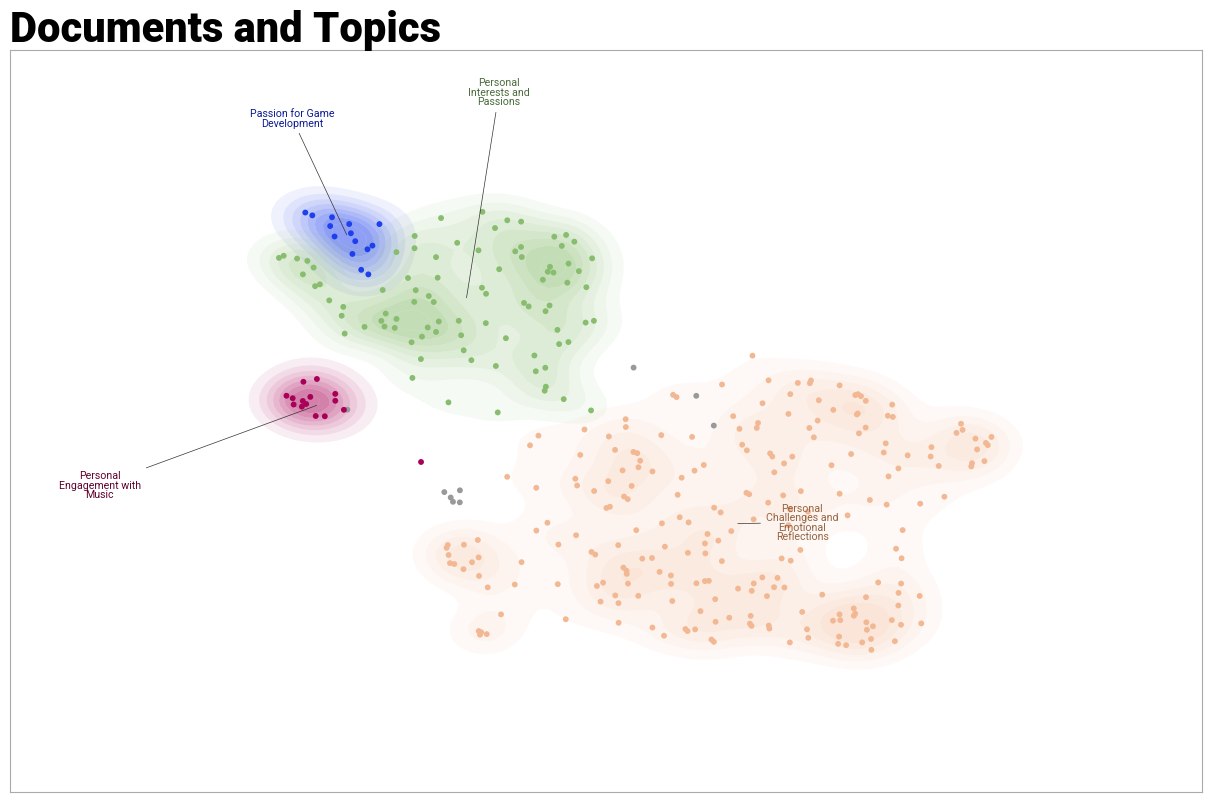

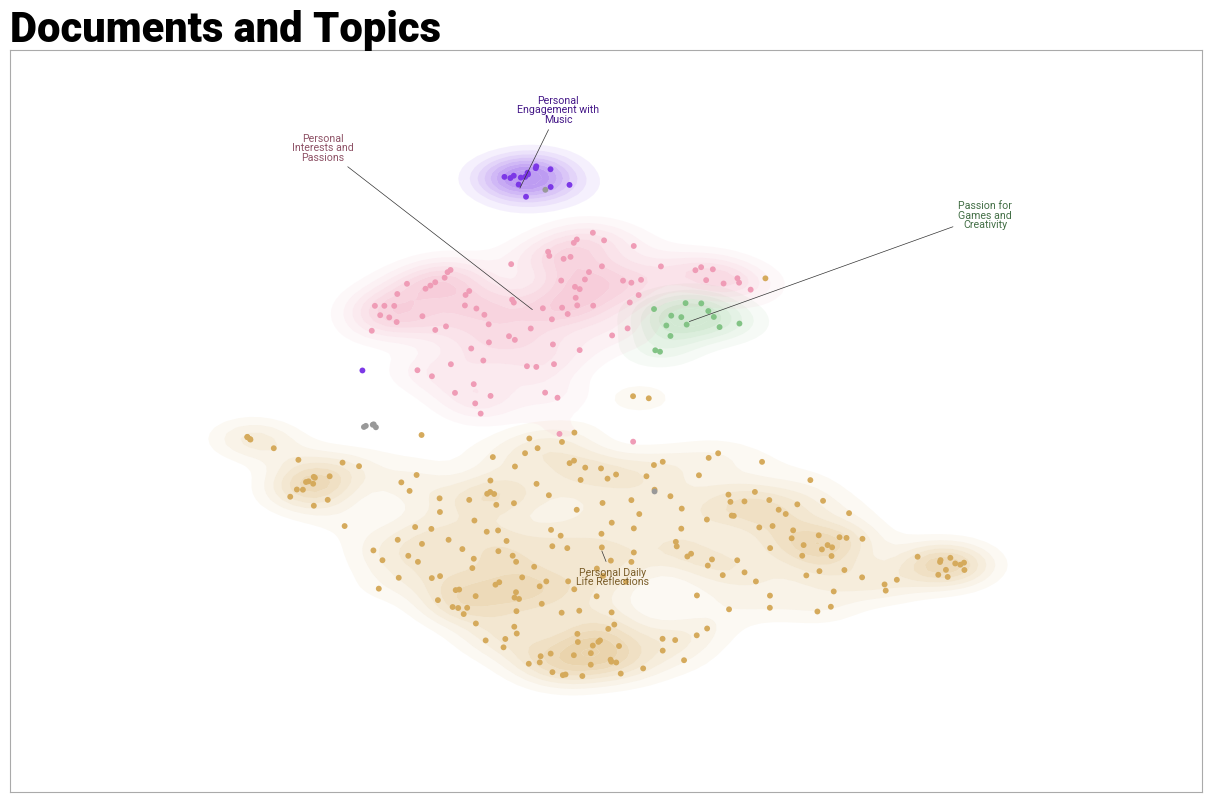

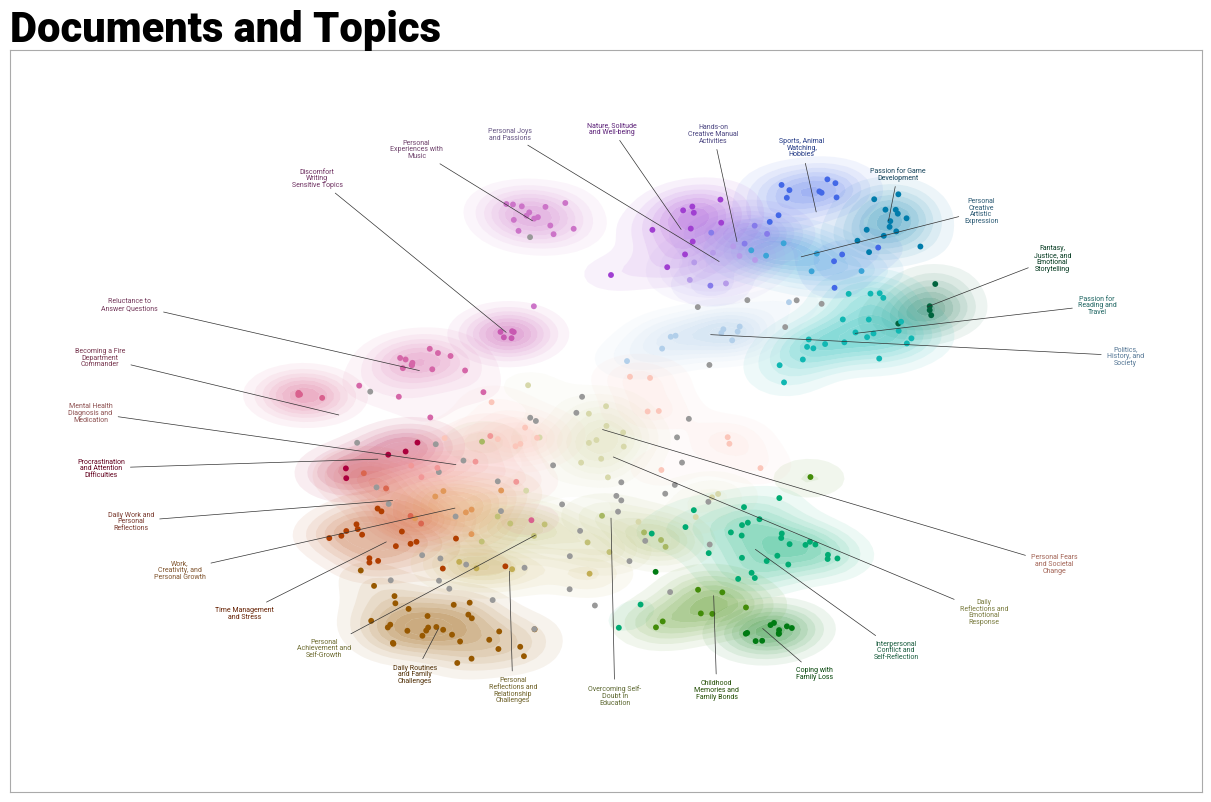

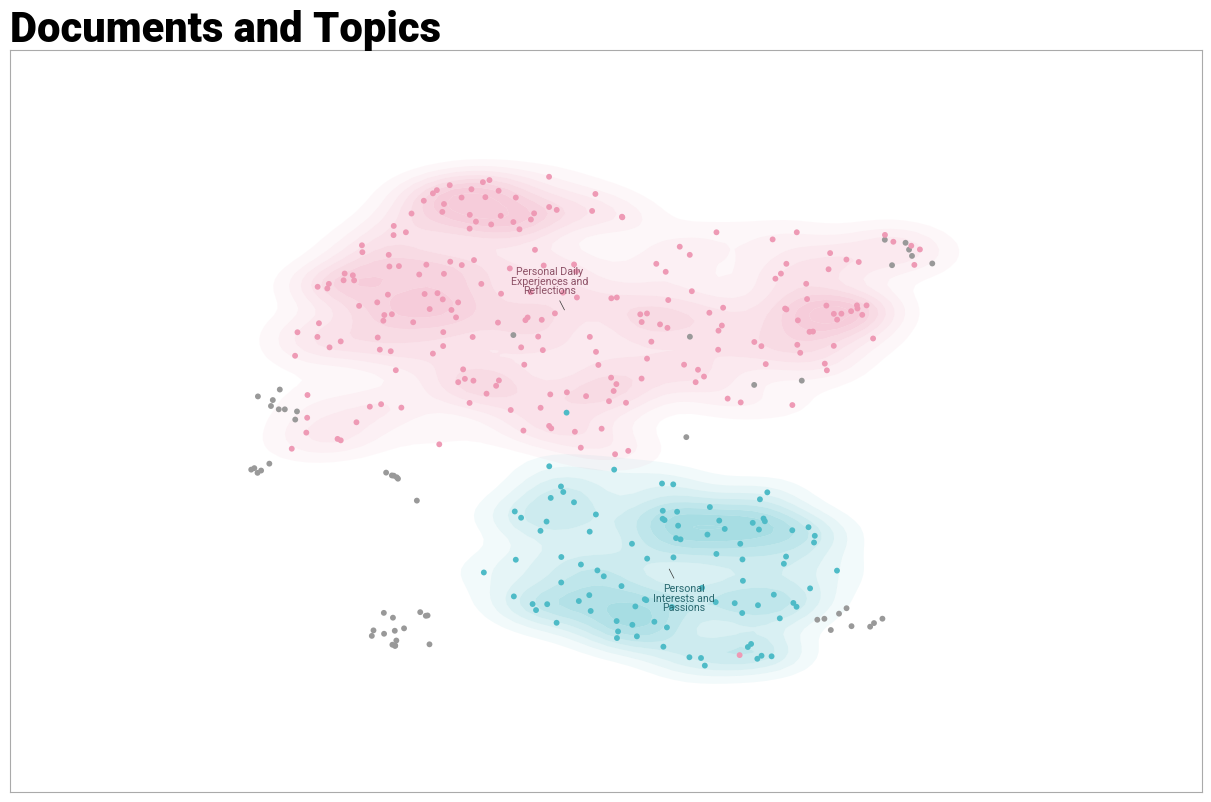

In [ ]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)